## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [1]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:
    val=0
    for i,j in edges:
        val+=(1-2*b[i])*(1-2*b[j])

    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

-5
[1, 0, 0, 1, 1]


#### visualization of the graph

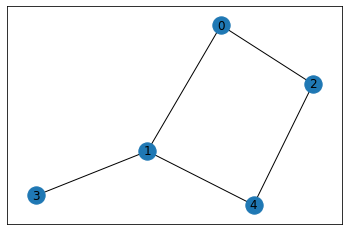

In [2]:
import networkx as nx
import matplotlib.pylab as plt
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)
plt.show()

In [3]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [4]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

In [5]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer
    for qbit in range(n_qubits):
        layer.apply(RX(theta), qbit)
    for i, j in edges:
        layer.apply(U_ZZ(2*beta), i, j)
    
    return layer

### Question 4

In [6]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit
    #prog.apply(routine, qbit)
    
    for i in range(n_qubits):
        prog.apply(H, qubits[i])
        
    for j in range(n_layers):
        theta, beta = parameters[2*j], parameters[2*j+1]
        prog.apply(one_qaoa_layer(n_qubits, edges, theta, beta), qubits)
                                                                       
    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO
    obs = 0
    for sample in result:
      b = sample.state.bitstring
      val = sum([(1-2*int(b[i]))*(1-2*int(b[j])) for (i,j) in edges])
      obs += val*sample.probability
        # this loop is over all 2**nqubits states.
        # sample.state.bitstring contains the qubit values (nqubits 0 or 1)
      
    # END TODO
    return obs
    
        

In [7]:
import numpy as np
np.random.random(3)

array([0.20816574, 0.66225078, 0.7519223 ])

In [8]:
from scipy.optimize import minimize


### Random initialisation

### Question 5: 
réponse à la question: 10

1.4689906630911103 -0.7114885027587717 -1.6180897084582821 -2.365368997186472 -2.5286950902146823 -2.734527377201975 -3.0563243282940897 -3.392149910769492 -3.5099055061817057 -3.6812174879812827 -3.9088432293520814 -4.19019910642155 -4.492082073585889 -4.549942078094736 -4.56266024940511 -4.58584310926318 -4.625363407837719 -4.675201974296524 -4.688130874688455 -4.693277961035359 -4.698335890346161 -4.7038251006535265 -4.71047371247405 -4.72064972606039 -4.7295353673689355 -4.733561568391236 -4.740166460771911 -4.7471921320827635 -4.750009973482209 -4.75442806355862 -4.762103721716951 -4.773158230765841 -4.788902875982612 -4.807274632358145 -4.817166928370584 -4.82972130854182 -4.833756105749231 -4.839051015997999 -4.841239230562974 -4.844335850268398 -4.847687421182723 -4.8520731837021405 -4.855010728217077 -4.856603395470168 -4.8574570320209185 -4.8589048273398365 -4.861456387063422 -4.86567249743808 -4.869812930461929 -4.871162490538731 -4.872691835460616 -4.872948557185456 -4.8732

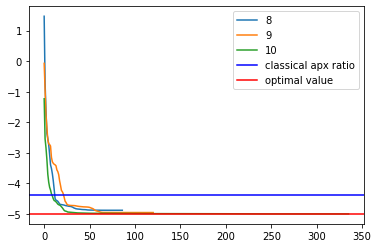

In [9]:
import matplotlib.pylab as plt


for nlayers in range(8,11,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

### Question 6: smart initialization

-0.004920539953585018 -0.05744534254688671 -0.08029003016457775 -0.30819027389435816 -0.697422336333792 -1.943497933783929 -1.987551896241416 -2.315985632817671 -2.4358493965582935 -2.447615567767016 -2.4656642838572354 -2.4723105522939526 -2.4723272368803 -2.4723393467262733 -2.472362387171678 -2.4724059536646834 -2.4724853930023167 -2.4726148484597905 -2.4727272269082294 -2.4727479984055125 -2.472762300907241 -2.472762693878666 -2.472762704457204 -2.472762704481151 -0.019345808995953645 -0.12815032844086066 -0.18057218037108794 -0.24227636717675743 -0.503634745461764 -0.7535496991785839 -1.143216963438382 -1.8108457078929552 -2.1296519704172896 -2.206051029123013 -2.274521601761046 -2.364873009353242 -2.41471146712076 -2.4195554307234857 -2.4223402239317777 -2.4272494773033864 -2.4360259800890702 -2.4509045889003622 -2.470526313016886 -2.4769166603516557 -2.4813590433467976 -2.486194747039648 -2.4876499192263855 -2.488166811129916 -2.4883675477990983 -2.4883803590085853 -2.4883820599

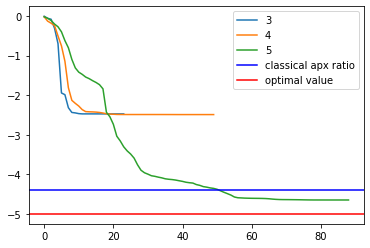

In [11]:
T = 1.
p = 100

for nlayers in range(3,6,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []
    for k in range(1,p+1):
      theta_k = T/(2*p) * (1 - k/p)
      beta_k = T*k/p**2
      parameters_init.append(theta_k)
      parameters_init.append(beta_k)

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()